In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import os
import re
import gensim
from gensim.models import KeyedVectors as word2vec
from sklearn.utils import resample
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, confusion_matrix, classification_report, make_scorer, log_loss
from xgboost import plot_importance
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt
import time
from datetime import datetime
from time import gmtime, strftime
from copy import deepcopy
import sys
from glob import glob
import warnings
from unidecode import unidecode
sys.path.insert(1, '../word2vec/')
import regex
warnings.filterwarnings('ignore')

/home/groot/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
w2v_path = '../word2vec/models/vectors.kv'
w2v_model = word2vec.load(w2v_path)
w2v_model.init_sims(replace=True)

In [3]:
stop_words = set(pd.read_csv('../word2vec/input/stop_words_.txt', names=['stop']).stop)
stop_words = dict.fromkeys(stop_words,1)
def remove_stop_words(sentence, stop_words=stop_words):
    stop = []
    if type(sentence) != list:
        return []
    for word in sentence:
        if not stop_words.get(word):
            stop.append(word)
    return stop

In [4]:
def get_regex_bad():
    bad = set(pd.read_csv('../word2vec/input/bad.csv', names=['words']).words)
    reg = '\\bcu\\b'
    for value in bad:
        reg += '|\\b' + value
    return reg

reg_bad = get_regex_bad()
def pre_classifier(sentence):
    quant = len(re.findall(reg_bad, sentence))
    return quant

In [5]:
def rename_wrong_words(sentences, wrong_worgs=regex.WRONG_WORDS):
    sentences = sentences.replace(to_replace=wrong_worgs, regex=True)
    return sentences

In [6]:
def text_normalizer(sentences, num_to_word=regex.NUM_TO_WORD, regex_dic=regex.REGEX_DIC):
    sentences = sentences.apply(unidecode)
    sentences = sentences.replace(to_replace=num_to_word, regex=True)
    sentences = sentences.replace(to_replace=regex_dic, regex=True)
    return sentences

In [7]:
def clean_text(sentences):
    sentences = sentences.apply(lambda s: str(s).lower())
    sentences = text_normalizer(sentences)
    sentences = rename_wrong_words(sentences)
    sentences = sentences.str.findall(r'[a-z]+|[\?!,]')
    return sentences

In [8]:
# Função responsável por encontrar o vetor que representa todas as palavras de uma sentença
def featureVecMethod(sentence, model, num_features):
    featureVec = np.zeros(num_features, dtype="float32")
    vec_checksum = np.zeros(num_features, dtype="float32")
    nwords = 0

    for i, word in enumerate(sentence):
        try:
            vec = model.wv[word]
            nwords = nwords + 1
            featureVec = np.add(featureVec, vec)
            vec_sum = np.multiply(vec, i+1)
            vec_checksum = np.add(vec_checksum, vec_sum)
        except:
            pass

    # Cálculo do 'vetor médio'
    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)

    # Esse ajuste é necessário para que o algoritmo leve em conta a ordem das palavras
    vec_checksum = np.sum(vec_checksum)
    featureVec = np.append(featureVec, vec_checksum)
    return featureVec

In [9]:
# Função retorna o conjunto de vetores das sentenças
def getAvgFeatureVecs(sentences, model, num_features):
    reviewFeatureVecs = np.zeros((len(sentences),num_features+1),dtype="float32")
    for i, sentence in enumerate(sentences):     
        reviewFeatureVecs[i] = featureVecMethod(sentence, model, num_features)        
    return reviewFeatureVecs

In [10]:
# Função responsável pela limpeza dos textos, adição de feature e retorno do dataframe com os vetores
# num_features representa a quantidade de dimensões que cada palavra tem no modelo word2vec
def transform(sentences, w2v_model, num_features=300):
    sentences = clean_text(sentences)
    col_names = ['c'+str(i+1) for i in range(0,num_features+1)]
    vecs = pd.DataFrame(getAvgFeatureVecs(sentences, w2v_model, num_features), columns=col_names)
    pre = pd.DataFrame()
    sentences = sentences.str.join(' ')
    pre["bad"] = sentences.apply(pre_classifier)
    frame = pd.concat([pre, vecs], axis=1)    
    return frame

In [11]:
# Função retorna a qual classe cada comentário faz parte, positivo ou negativo 
def predict(sentences, w2v_model, xgb_model, num_features=300):
    sentiment_vec = transform(sentences, w2v_model, num_features)
    score = xgb_model.predict_proba(sentiment_vec)
    score = pd.DataFrame(score, columns=xgb_model.classes_)
    for i in score.columns:
        score[i] = score[i].apply(lambda x: format(x*100, ".2f"))
    sentences = pd.DataFrame({'texto': sentences})
    return pd.concat([sentences, score], axis=1)

In [12]:
def train(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
            eval_metric=['logloss', 'auc'], early_stopping_rounds=100,
            verbose=False)    
    return model

In [13]:
def eval_train(model):
    results = model.evals_result()
    epochs = len(results['validation_0']['logloss'])
    x_axis = range(0, epochs)

    # plot log loss
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
    axes[0].plot(x_axis, results['validation_0']['logloss'], label='Train')
    axes[0].plot(x_axis, results['validation_1']['logloss'], label='Test')
    axes[0].legend()
    axes[0].set(xlabel = 'Epochs: ' + str(epochs), ylabel = 'Log Loss')
    axes[0].set_title('XGBoost Log Loss')

    # plot AUC
    axes[1].plot(x_axis, results['validation_0']['auc'], label='Train')
    axes[1].plot(x_axis, results['validation_1']['auc'], label='Test')
    axes[1].legend()
    plt.xlabel('Epochs:' + str(epochs))
    plt.ylabel('Acurácia')
    axes[1].set_title('XGBoost Acurácia')
    plt.show()

# Carregar dados

In [14]:
pos = pd.read_csv("input/positivo.csv")
neg = pd.read_csv("input/negativo.csv")
sentiment = pd.concat([pos,neg]).drop_duplicates().reset_index(drop=True)
sentiment = sentiment.fillna('')

# Processar dados

### Transformar textos em vetores

In [15]:
trainVecs = transform(sentiment['review'], w2v_model)
data = pd.concat([sentiment.categoria, trainVecs], axis=1)
data = data.drop_duplicates()

### Balancear classes

In [16]:
data.groupby('categoria')['categoria'].count()

categoria
-1    5729
 1    4721
Name: categoria, dtype: int64

In [17]:
df_maior = data[data.categoria==-1]
df_menor = data[data.categoria==1]
df_ = resample(df_maior, replace=True, n_samples=df_menor.shape[0], random_state=123) 
data = pd.concat([df_menor, df_])
data.categoria.value_counts()

-1    4721
 1    4721
Name: categoria, dtype: int64

### Separar dados de treino e teste

In [18]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 1:], data.iloc[:, 0],
                                                    train_size=.8, stratify=data.iloc[:, 0],
                                                    random_state=99)

# Treinamento

### Processo preliminar com parâmetros default

In [19]:
xgb_model = xgb.XGBClassifier(
                learning_rate=0.1,
                nthread=-1,
                random_state=99,
                objective='binary:logistic',
                booster='gbtree'
            )

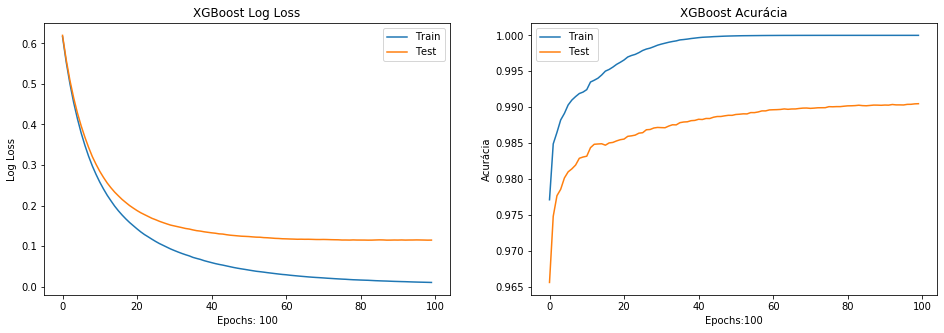

In [20]:
xgb_model = train(xgb_model, X_train, X_test, y_train, y_test)
eval_train(xgb_model)

### Avaliar métricas

In [21]:
# Fazer previsões com dados-teste
y_pred = xgb_model.predict(X_test)
predictions = [value for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Acurácia: %.2f%%" % (accuracy * 100.0))

Acurácia: 96.19%


### Grid Search

In [24]:
scorers = {
    'accuracy_score': make_scorer(accuracy_score),
    'neg_log_loss': make_scorer(log_loss)
}
params = {
        'subsample': [i*.1 for i in range(5,10)],
        'colsample_bytree': [i*.1 for i in range(5,10)],
        'max_depth': [i for i in range(5,13,2)],
        'n_estimators': [i for i in range(100, 300, 50) ]
        }


skf = StratifiedKFold(n_splits=3, shuffle = True)

grid = GridSearchCV(xgb_model, 
                    param_grid = params, 
                    scoring = scorers, 
                    n_jobs = -1, 
                    cv = skf.split(X_train, y_train),
                    refit = 'accuracy_score',
                    verbose=False,
                    return_train_score=True)

grid.fit(X_train, y_train)
print('\n Best estimator:')
print(grid.best_estimator_)
print('\n Best score:')
print(grid.best_score_ * 2 - 1)
print('\n Best parameters:')
print(grid.best_params_)

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 29.4min
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed: 58.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 100.6min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed: 163.4min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 174.8min finished



 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7000000000000001, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=-1, nthread=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=99, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.6000000000000001,
              tree_method=None, validate_parameters=False, verbosity=None)

 Best score:
0.9288663913680564

 Best parameters:
{'colsample_bytree': 0.7000000000000001, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.6000000000000001}


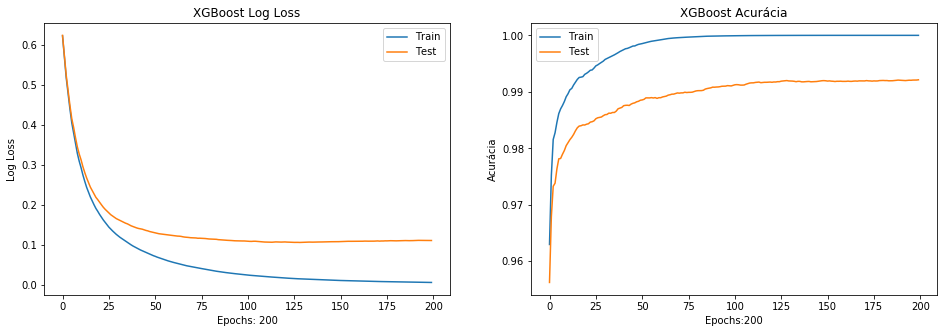

In [22]:
xgb_model.set_params(**grid.best_params_)
xgb_model = train(xgb_model, X_train, X_test, y_train, y_test)
eval_train(xgb_model)

### Avaliar métricas

In [23]:
# Fazer previsões com dados-teste
y_pred = xgb_model.predict(X_test)
predictions = [value for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Acurácia: %.2f%%" % (accuracy * 100.0))

Acurácia: 96.45%


In [25]:
#Matriz de confusão
conf = confusion_matrix(y_test, y_pred)
pd.DataFrame(conf, columns=xgb_model.classes_, index=xgb_model.classes_)

,-1,1
-1,919,25
1,42,903


# Testar modelo

In [26]:
sentences = [ "Ótimo! Permite acompanhar sua conta direto no celular. Recomendo!",
             "Não trava e ajuda vc evitar de ir ao banco",
             "Melhor app de banco.... fantástico...me surpreende a cada dia e a cada vez que necessito de alternativas....",
              "Pode confiar", 
             "gosto muito",
             "boa",
             "Muito bom, sem burocracia de fila e espera.",
             "Mui raramente não funciona. Melhor que o do Santander e da Caixa.",
             "Eita fila que demora!",
              "Minha senha de 6 dígitos está bloqueada",
              "Nota maxima para o app",
              "App muito bom, so que não",
              "mto dificil de ser utilizado, poderia ser mais prático como o da Caixa",
            "O banco não pensa no cliente",
             "nao, gosto muito do atendimento",
             "nao gosto muito do atendimento",
             "O app realmente funciona bem,nunca me deixa na mão"
             ]

In [27]:
predict(pd.Series(sentences), w2v_model=w2v_model, xgb_model=xgb_model)

,texto,-1,1
0,Ótimo! Permite acompanhar sua conta direto no ...,0.06,99.94
1,Não trava e ajuda vc evitar de ir ao banco,3.74,96.26
2,Melhor app de banco.... fantástico...me surpre...,0.38,99.62
3,Pode confiar,4.45,95.55
4,gosto muito,0.16,99.84
5,boa,0.01,99.99
6,"Muito bom, sem burocracia de fila e espera.",2.38,97.62
7,Mui raramente não funciona. Melhor que o do Sa...,2.71,97.29
8,Eita fila que demora!,98.45,1.55
9,Minha senha de 6 dígitos está bloqueada,99.55,0.45


# Salvar modelo

In [28]:
filename = filename = 'models/xgb_model_sentiment-' + str(int(time.time())) + '.bin'
xgb_model.save_model(filename)
print(filename)

models/xgb_model_sentiment-1589678886.bin
